In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
# Import libraries
# The only non-publicly available function is mtaper_specgram

import sys
import os
import time
import gc
import copy
import math

import cv2
import imageio

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
import numpy.matlib

import scipy
import scipy.signal

import sklearn as sk
import sklearn.decomposition
import skimage.draw

import torch
import torch.cuda

import multiprocessing
from multiprocessing import Pool

import librosa

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import pywt

import tensortools as tt

In [3]:
sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/face-rhythm/functions')

import mtaper_specgram
# from mtaper_specgram import mtaper_specgram

# import scaleogram as scg

 

In [4]:
sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

import tensorly as tl
import tensorly.decomposition
import tensorly.random

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the import cell block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Use the Save and Load cell blocks to save and load data after long calculations. It seriously helps with iterating, debugging, and memory allocation.
    - These arrays can be BIG. I regularly go past 128 GB when running my data through. It's often easiest to just restart the kernel, load in just the precomputed variables needed and run the script in the middle (skipping all the previous computations)
- There are two cell blocks for calculating the optic flow (parameters set independently as well), one single-threaded and one multi-threaded. Do parameter tuning on the single-threaded one so you can quit out of it, as well as watch the calculation as it happens with showVideo_pref=1. The multi-threaded one is only faster if you have a lot of cores in your CPU (>10), then it's faster, else stick with the single-threaded version and set showVideo_pref=0.
- Parameter tuning should be pretty easy. Most of the cell blocks can be halted in the middle of computation so you can just look at a small bit of the data, tune a parameter and then rerun the code

### The most important parameters:  
***(Consider all of these before you run the code for the first time)***
- Optic flow params:
    - **'spacing'**: ~ 3 to 12. Spacing between dots, in pixels. Inversely related to number of dots to use in the calculation. Try to keep the number of dots below 2000 if possible (eats up memory and computation time). More dots generally means better final results, more robust to outliers and weird stuff. I'd make the spacing as small (more dots) as you can go before you run out of RAM in the final calculations
    - **lk_params 'win_size'**: ~ 25,25 to 80,80. This is the spatial integration window for the optical flow measurement. Try to make it as small as possible without it becoming unstable. The two values are for X and Y length of square integration window. Probably keep the same for most applications
- Outlier removal params:
    - **outlier_threshold_positions**: ~ 20 to 100. If a dot strays more than this many pixels away from its anchor position, its displacement in the dimension it cross the threshold in, for those time points (and some time points around it, see params below), for that dot only, will be set to zero
    - **outlier_threshold_displacements** ~ 5 to 25. Similar to above, but for displacement. Only the outlier time points are removed (no window around outliers considered).
    - **framesHalted_beforeOutlier**: ~ 0 to 30. The number of frames to also remove before detected outlier events. Consider what is causing your outlier event. If it is an arm movement or something, how long does such a movement last? How long before it will cause a dot to move to the outlier threshold?
    - **framesHalted_afterOutlier**: ~ 0 to 10. Simlar to above but for after an outlier event is detected
    - **relaxation_factor** : ~ 0.03 to 0.1. This is the rate of the exponential decay / relaxation / attraction back to the anchor position that a point undergoes. It is meant to prevent baseline drift. Think of it like a high pass on the dot position trace
- Spectral analysis params:
    - **win_len**: ~ 0.1 to 1.0. The length of the time window used for the short-time Fourier transform. Longer gives better spectral resolution, shorter gives better temporal resolution. There are several other parameters that are related but this is the most important. Longer windows (along with decreasing the overlap parameter) also decrease the size of the output spectrograms, which can help with memory and computation time in the subsequent analyses
- TCA:
    - **rank = 6**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors

# Goals for improving code:


## Backend:

Where the code is slowest:
- Calculating the optic flow displacement field: ~30 min
    - There are now two cell blocks, one that doesn't use multiprocessing, and one that does. The multiprocessing one is about twice as fast on my machine (36 cores), but might not be on rigs with fewer cores. OpenCV's lucas-kanande algorithm has some multiprocessing built in which is why improvement is sublinear
- The tensor decomposition. Tensorly is great and even uses ML packages as backends (torch, tf, etc), but it seems far from optimal. It runs fast on a GPU, but minibatching isn't implemented so that caps the maximum size of the data you can put in. Improvements could come from the following:
    - Building an optimal training set (ie subsampling time points where informative things are happening)
    - Iterative training by initializing with learned weights before training on new data (aka janky minibatching)
- Spectral analysis. This one is not as slow as the above, and is already semi optimized, but if you think one of the JIT, precompilation, or accelerator methods is appropriate here, it could help (numba, jax, pypy, etc.)

Structural improvements to be made:
- Outlier handling. It's a bit basic right now. I'm not sure what a better model would look like, but I'm open to suggestions. One issue is that pausing pixels (or canceling either the x or y velocities) results in correlated variance of an artefact (the grooming event or just poor displacement calculation). Devaluing those points at those samples could help model fitting.
- Spectral analysis. This problem is well suited for multi-resolution analysis. I got a continuous wavelet transform working well with continuous morlet wavelets, but it would probably be smarter to use a discrete wavelet transform with an orthogonal wavelet.
- Calculate in color. Currently I convert every frame to greyscale. Color holds information that could be usefull
- Improved displacement field calculation:
    - Use a fancier method. There are better ones out there that integrate image gnostic information. Standard image tracking models usually don't work so well, but a decent mixed model could be perfect here
    - A very simple mixed model we could implement: Build a kalman filter like inference model using an observation model (something super simple like a translation offset calculated from cross correlating a small window with the region arround; basically motion correction), and a kinematic model (from the optic flow).
- OpenCV really isn't used that much anymore in this code. It's just used for metadata gathering. Should be removed since opencv can be weird to install sometimes
    
Simple UI improvements:
- Notice that there are cell blocks for saving and loading. These are pretty jank. Not sure how to best to improve.
- Never figured out how to save Tensorly tensor objects. Would be nice not to have to convert the output kruskal tensor as numpy file, and would be nice to be able to save the input dense tensor to disk


## Packaging:
This analysis will be useful primarily by people with very little computational skill. So effort must be made to minimize boilerplate

Goals:
- Moonshot:
    - Zero programming skill required. End-user opens an .exe file on their windows machine and a GUI pops up that just works. (PyInstaller)
- Reach:
    - Install Anaconda, pip install this package, python -m this package, GUI pops up and you're good to go
- Par:
    - A well functionalized package with tunable parameters; a pip install
- Fine:
    - A few well commented jupyter notebooks



In [5]:
### find version of openCV
# script currently works with v4.4.0
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# print(cv2.getBuildInformation())

### find version of pytorch
print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

OpenCV version: 4.4.0
Pytorch version: 1.7.0
Autodetected operating system: Linux. Using "/" for directory slashes


In [6]:
### IMPORT VIDEOS
## Define DIRECTORY of video(s) to use and IMPORT videos (as read objects) into openCV
## Be careful to follow input the directories properly below. Input directory
## and file name (or file name prefix) in either the m

# This option imports all of the videos with a defined file name prefix in a folder
# OR just imports a single defined file
multiple_files_pref = 1

# dir_vid = r'/media/rich/bigSSD RH/tmp_download'
dir_vid = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3'

# Used only if 'multiple_files_pref'==1
fileName_vid_prefix = 'cam3_2020-11-02-185732-' 
fileName_vid_numDigitsInIteration = 4  # number of digits in the movie (used when movie is broken up into chunks)
fileName_vid_suffix = '.avi'

# Used only if 'multiple_files_pref'==0
fileName_vid = 'gmou06_082720_faceTrack_session1_DeInter100.avi'


### == IMPORT videos ==
print_fileNames_pref = 1

if multiple_files_pref:
    ## first find all the files in the directory with the file name prefix
    fileNames_allInPathWithPrefix = []
    for ii in os.listdir(dir_vid):
        if os.path.isfile(os.path.join(dir_vid,ii)) and fileName_vid_prefix in ii:
            fileNames_allInPathWithPrefix.append(ii)
    numVids = len(fileNames_allInPathWithPrefix)
    
    ## make a variable containing all of the file paths
    path_vid_allFiles = list()
    for ii in range(numVids):
        path_vid_allFiles.append(f'{dir_vid}{slash_type}{fileNames_allInPathWithPrefix[ii]}')
        
else: ## Single file import
    path_vid = f'{dir_vid}{slash_type}{fileName_vid}'
    path_vid_allFiles = list()
    path_vid_allFiles.append(path_vid)
    numVids = 1
path_vid_allFiles = sorted(path_vid_allFiles)
        
## get info on the imported video(s): num of frames, video height and width, framerate
if multiple_files_pref:
    path_vid = path_vid_allFiles[0]
    video = cv2.VideoCapture(path_vid_allFiles[0])
    numFrames_firstVid = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    numFrames_allFiles = np.ones(numVids) * np.nan # preallocation
    for ii in range(numVids):
        video = cv2.VideoCapture(path_vid_allFiles[ii])
        numFrames_allFiles[ii] = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    numFrames_total_rough = np.uint64(sum(numFrames_allFiles))
        
    print(f'number of videos: {numVids}')
    print(f'number of frames in FIRST video (roughly):  {numFrames_firstVid}')
    print(f'number of frames in ALL videos (roughly):   {numFrames_total_rough}')
else:
    video = cv2.VideoCapture(path_vid_allFiles[0])
    numFrames_onlyVid = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    numFrames_total_rough = numFrames_onlyVid
    numFrames_allFiles = numFrames_total_rough
    print(f'number of frames in ONLY video:   {numFrames_onlyVid}')
    

Fs = video.get(cv2.CAP_PROP_FPS) ## Sampling rate (FPS). Manually change here if necessary
print(f'Sampling rate pulled from video file metadata:   {round(Fs,3)} frames per second')
    
if print_fileNames_pref:
    print(f'\n {np.array(path_vid_allFiles).transpose()}')

    
video.set(1,1)
ok, frame = video.read()
vid_height = frame.shape[0]
vid_width = frame.shape[1]

number of videos: 42
number of frames in FIRST video (roughly):  11166
number of frames in ALL videos (roughly):   469751
Sampling rate pulled from video file metadata:   120.163 frames per second

 ['/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0000.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0001.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0002.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0003.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0004.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/cam3_2020-11-02-185732-0005.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102

In [ ]:
params_video = dict([
    ('Fs', Fs), 
    ('vid_height', vid_height), 
    ('vid_width', vid_width)
    ])

In [7]:
### Select POLYGON SUBFRAME for DISPLACEMENT Eignfaces
## This block of code will pop up a little GUI. Click around the
## region of the face that you want to include in the analysis.
## When you are done, press enter twice to accept and exit the GUI.

vidToSet = 1 # 1 indexed. Sets the video to use to make an image
frameToSet = 2 # 1 indexed. Sets the frame number to use to make an image

path_vid = path_vid_allFiles[vidToSet-1]
video = cv2.VideoCapture(path_vid)
    
video.set(1,frameToSet)
ok, frame = video.read()
cv2.imshow('window', frame)
# cv2.waitKey(1);

## these colors aren't really important, they just allow the text and lines in the GUI to change color
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (255, 255, 0)
MAGENTA = (255, 0, 255)
YELLOW = (0, 255, 255)
WHITE = (255, 255, 255)

colors = (WHITE , RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

## The below block is adapted code. It makes a GUI, then allows a user to click to define the
## outline of the ROI to use. 'pts' are the clicked points.
pts = [] # prepare for appending. I'm using this global in functions like a pleb. please forgive
def draw(x):
    d = cv2.getTrackbarPos('thickness', 'window')
    d = 1 if d==0 else d
    i = cv2.getTrackbarPos('color', 'window')
    color = colors[i]
    cv2.polylines(frame, np.array([pts]), False, color, d)
    cv2.imshow('window', frame)
    text = f'color={color}, thickness={d}'
#     cv2.displayOverlay('window', text)

def mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pts.append((x, y))
        draw(0)

cv2.setMouseCallback('window', mouse)
cv2.createTrackbar('color', 'window', 0, 6, draw)
cv2.createTrackbar('thickness', 'window', 1, 10, draw)
draw(0)
cv2.waitKey(0)

# print(f'all points: {pts}')

## The below block "fills in" the indices of all the points within the above defined bounds
mask_frame = np.zeros((frame.shape[0] , frame.shape[1]))
pts_y, pts_x = skimage.draw.polygon(np.array(pts)[:,1], np.array(pts)[:,0])
mask_frame[pts_y, pts_x] = 1

cv2.imshow('window', frame * np.uint8(np.repeat(mask_frame[:,:,None] , 3 , axis=2)))

cv2.waitKey(0)
cv2.destroyAllWindows()

## below are the indices of the rectangular bounds surrounding the ROI
# bounds of polygon
bbox = np.zeros(4)
bbox[0] = np.min(np.where(np.max(mask_frame , axis=0))) # x top left
bbox[1] = np.min(np.where(np.max(mask_frame , axis=1))) # y top left
bbox[2] = np.max(np.where(np.max(mask_frame , axis=0))) - bbox[0] # x size
bbox[3] = np.max(np.where(np.max(mask_frame , axis=1))) - bbox[1] # y size
bbox = np.int64(bbox)

bbox_subframe_displacement = bbox
pts_displacement , pts_x_displacement , pts_y_displacement = pts , pts_x , pts_y
mask_frame_displacement = mask_frame

# OUTPUTS: 
# bbox_subframe_displacement [bounding box of the subframe containing all the dots]
# pts_displacement [indices of all the vertices]
# pts_x_displacement [indices of all the POINTS]
# pts_y_displacement [indices of all the POINTS]
# mask_frame_displacement [boolean mask of indices to include]

In [9]:
cv2.destroyAllWindows()

In [10]:
pts_all = dict([
    ('bbox_subframe_displacement', bbox_subframe_displacement), 
    ('pts_displacement', pts_displacement), 
    ('pts_x_displacement', pts_x_displacement),
    ('pts_y_displacement', pts_y_displacement),
    ('mask_frame_displacement', mask_frame_displacement)
    ])

In [11]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'pts_all'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , pts_all)

In [6]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

load_name = f'pts_all'
load_fullPath = f'{load_dir}/{load_name}.npy'
pts_all = np.load(load_fullPath , allow_pickle=True)[()]
bbox_subframe_displacement = pts_all['bbox_subframe_displacement']
pts_displacement = pts_all['pts_displacement']
pts_x_displacement = pts_all['pts_x_displacement']
pts_y_displacement = pts_all['pts_y_displacement']
mask_frame_displacement = pts_all['mask_frame_displacement']

## SINGLE-THREAD  Optic flow calculation
### No need to run this if multi-threaded calculation used instead

In [ ]:
### IMPORT and CALCULATE DISPLACEMENT FIELD
### __SINGLE(ish) THREAD__ VERSION

### Calculate DISPLACEMENT FIELD using dot grid within subframe
## The only thing coming out of the code block that matters is the 'displacements' variable

## I use imageio (ffmpeg) because openCV doesn't seem to import as many frames as imageio does (wtfffff), 
## and I can't preallocate because openCV and imageio give inaccurate total frame numbers from metadata (WTFFFF).

### == PREFERENCES ==
vidNums_toUse = range(numVids) ## 0 indexing
spacing = 3  ## This is the distance between points in the grid (both in x and y dims)

showVideo_pref = 0  ## much faster when video is off
dot_size = 1  ## for viewing purposes

## below will print the fps ever 'fps_counterPeriod' . Useful for checking the speed of import.
## Best to turn off when doing a full run. (this is mostly for optimizing and debugging)
printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

## Parameters for lucas kanade optical flow
## win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
## max level: only moderate effects if everything working properly. Keep around 3.
## criteria values have to do with the search algorithm. For speed: EPS small, COUNT big.
lk_params = dict( winSize  = (35,35),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.001))


### == CALCULATION ==

## Make point cloud
pts_spaced = np.ones((np.int64(bbox_subframe_displacement[3] * bbox_subframe_displacement[2] / spacing) ,2)) * np.nan ## preallocation
cc = 0 ## set idx counter

# make spaced out points
for ii in range(len(pts_x_displacement)):
    if (pts_x_displacement[ii]%spacing == 0) and (pts_y_displacement[ii]%spacing == 0):
        pts_spaced[cc,0] = pts_x_displacement[ii]
        pts_spaced[cc,1] = pts_y_displacement[ii]
        cc = cc+1

pts_spaced = np.expand_dims(pts_spaced,1).astype('single')
pts_spaced = np.delete(pts_spaced , np.where(np.isnan(pts_spaced[:,0,0])) , axis=0)
print(f'number of points: {pts_spaced.shape[0]}')


## Define random colors for points in cloud
color_tuples =  list(np.arange(len(pts_x_displacement)))
for ii in range(len(pts_x_displacement)):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
    
## Preallocate output variables

# I add a bunch of NaNs to the end because the openCV estimate is usually less than the actual number of frames
displacements = np.ones((pts_spaced.shape[0] , 2 , np.uint64(numFrames_total_rough + numFrames_total_rough*0.1 + (numVids * 1000)))) * np.nan 

## Preset point tracking variables
pointInds_toUse = copy.deepcopy(pts_spaced) 
pointInds_tracked = pointInds_toUse ## set the first frame to have point locations be positions in the point cloud
pointInds_tracked_tuple = list(np.arange(pointInds_toUse.shape[0])) 

## Main loop to pull out displacements in each video   
ind_concat = 0
fps = 0
tic_fps = time.time()
tic_all = time.time()
for vidNum_iter in vidNums_toUse:
    vid = imageio.get_reader(path_vid_allFiles[vidNum_iter],  'ffmpeg')
#     metadata = vid.get_meta_data()
        
    path_vid = path_vid_allFiles[vidNum_iter]  # get path of the current vid
    video = cv2.VideoCapture(path_vid)  # open the video object with openCV
    numFrames_rough = int(video.get(cv2.CAP_PROP_FRAME_COUNT))  # get frame count of this vid GENERALLY INACCURATE. OFF BY AROUND -25 frames

    frameToSet = 0
    frame = vid.get_data(0) # Get a single frame to use as the first 'previous frame' in calculating optic flow
    new_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
    old_frame = new_frame_gray
    
    
    print(f'\n Calculating displacement field: video # {vidNum_iter+1}/{numVids}')
#     while True:
    for iter_frame , new_frame in enumerate(vid):
        new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale

        ##calculate optical flow
        pointInds_new, status, error = cv2.calcOpticalFlowPyrLK(old_frame, new_frame_gray, pointInds_toUse, None, **lk_params)  # Calculate displacement distance between STATIC/ANCHORED points and the calculated new points. Also note the excluded 'NextPts' parameter. Could be used for fancier tracking

        ## Calculate displacement and place into variable 'displacements' (changes in size every iter)         
        if iter_frame ==0:
            displacements[:,:,ind_concat] = np.zeros((pts_spaced.shape[0] ,2))
        else:
            displacements[:,:,ind_concat] =  np.single(np.squeeze((pointInds_new - pointInds_toUse)))  # this is the important variable. Simply the difference in the estimate
        
        old_frame = new_frame_gray  # make current frame the 'old_frame' for the next iteration
        
        ## below is just for visualization. Nothing calculated is maintained
        if showVideo_pref:
            pointInds_tracked = pointInds_tracked + (pointInds_new - pointInds_toUse)  # calculate integrated position
            pointInds_tracked = pointInds_tracked - (pointInds_tracked -pointInds_toUse)*0.01  # multiplied constant is the relaxation term
            
            for ii in range(pointInds_tracked.shape[0]):
                pointInds_tracked_tuple[ii] = tuple(np.squeeze(pointInds_tracked[ii,0,:]))
                cv2.circle(new_frame,pointInds_tracked_tuple[ii], dot_size, color_tuples[ii], -1)

            cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames_rough}-ish', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'vid #: {vidNum_iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total_rough}-ish', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.imshow('test',new_frame)


            k = cv2.waitKey(1) & 0xff
            if k == 27 : break

        ind_concat = ind_concat+1
        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            
    ## Calculate how long calculation took
    elapsed = time.time() - tic_all
    if elapsed < 60:
        print(f'time elapsed: {np.uint32(elapsed)} seconds. Capture rate: {round(ind_concat/elapsed,3)} fps')
    else:
        print(f'time elapsed: {round(elapsed/60,3)} minutes. Capture rate: {round(ind_concat/elapsed,3)} fps')
        

numFrames_total = ind_concat-1
cv2.destroyAllWindows()

displacements = displacements[:,:,~np.isnan(displacements[0,0,:])]
    
print('===== Displacement calculation completed! =====')

number of points: 3707

 Calculating displacement field: video # 1/42
time elapsed: 1.314 minutes. Capture rate: 141.405 fps

 Calculating displacement field: video # 2/42
time elapsed: 2.667 minutes. Capture rate: 139.328 fps

 Calculating displacement field: video # 3/42
time elapsed: 4.045 minutes. Capture rate: 137.941 fps

 Calculating displacement field: video # 4/42
time elapsed: 5.413 minutes. Capture rate: 137.451 fps

 Calculating displacement field: video # 5/42
time elapsed: 6.868 minutes. Capture rate: 135.413 fps

 Calculating displacement field: video # 6/42


In [ ]:
## This cell block is here just because sometimes its nice to cancel early out of the iterative loading (above cell block) and just play with a short trace. This block cleans out the NaNs
displacements = displacements[:,:,~np.isnan(displacements[0,0,:])]  # this removes the trailing and interleaved NaNs in the arrays

## MULTI-THREAD  Optic flow calculation
### No need to run this if single-threaded calculation used instead
this struggles if too many dots are selected (memory overload)

In [12]:
### IMPORT and CALCULATE DISPLACEMENT FIELD : __PARALLEL VERSION__

## Important assumptions about using this code verses the single (ish) threaded version:
## 1. numFrames (per file) + 1000 (USING OPENCVs cv2.CAP_PROP_FRAME_COUNT) must be > true number of frames
##  as found using the imageio import method
## 2. Debugging is hard. If you interrupt the kernel while it's doing the parallel pool, the kernel is kind of fucked
##  and generally requires a restart
## 3. I haven't figured out how to track progress. I know there are probably ways to make wait bars, but I'll leave that
##  to a software engineer.

## comments below are the same as above (except for the multiprocessing related lines)

### Calculate DISPLACEMENT FIELD using dot grid within subframe
## The only thing coming out of the code block that matters is the 'displacements' variable

## I use imageio (ffmpeg) because openCV doesn't seem to import as many frames as imageio does (wtfffff), 
## and I can't preallocate because openCV and imageio give inaccurate total frame numbers from metadata (WTFFFF).

### == PREFERENCES ==
vidNums_toUse = range(numVids) ## 0 indexing
spacing = 3  ## This is the distance between points in the grid (both in x and y dims)

showVideo_pref = 0  ## much faster when video is off
dot_size = 1  ## for viewing purposes

## below will print the fps ever 'fps_counterPeriod' . Useful for checking the speed of import.
## Best to turn off when doing a full run. (this is mostly for optimizing and debugging)
printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

## Parameters for lucas kanade optical flow
## win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
## max level: only moderate effects if everything working properly. Keep around 3.
## criteria values have to do with the search algorithm. For speed: EPS small, COUNT big.
lk_params = dict( winSize  = (35,35),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.001))


### == CALCULATION ==

## Make point cloud
tic = time.time()

pts_spaced = np.ones((np.int64(bbox_subframe_displacement[3] * bbox_subframe_displacement[2] / spacing) ,2)) * np.nan ## preallocation
cc = 0 ## set idx counter

# make spaced out points
for ii in range(len(pts_x_displacement)):
    if (pts_x_displacement[ii]%spacing == 0) and (pts_y_displacement[ii]%spacing == 0):
        pts_spaced[cc,0] = pts_x_displacement[ii]
        pts_spaced[cc,1] = pts_y_displacement[ii]
        cc = cc+1

pts_spaced = np.expand_dims(pts_spaced,1).astype('single')
pts_spaced = np.delete(pts_spaced , np.where(np.isnan(pts_spaced[:,0,0])) , axis=0)
print(f'number of points: {pts_spaced.shape[0]}')


## Define random colors for points in cloud
color_tuples =  list(np.arange(len(pts_x_displacement)))
for ii in range(len(pts_x_displacement)):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
    
## Preallocate output variables

# I add a bunch of NaNs to the end because the openCV estimate is usually less than the actual number of frames
displacements = np.ones((pts_spaced.shape[0] , 2 , np.uint64(numFrames_total_rough + numFrames_total_rough*0.1 + (numVids * 1000)))) * np.nan 

## Preset point tracking variables
pointInds_toUse = copy.deepcopy(pts_spaced) 
pointInds_tracked = pointInds_toUse # set the first frame to have point locations be positions in the point cloud
pointInds_tracked_tuple = list(np.arange(pointInds_toUse.shape[0])) 

## Main loop to pull out displacements in each video   
ind_concat = 0
fps = 0
tic_fps = time.time()
tic_all = time.time()
# for vidNum_iter in vidNums_toUse:
def importVid(vidNum_iter):  # function needed for multiprocessing
    vid = imageio.get_reader(path_vid_allFiles[vidNum_iter],  'ffmpeg')
#     metadata = vid.get_meta_data()
        
    path_vid = path_vid_allFiles[vidNum_iter]  # get path of the current vid
    video = cv2.VideoCapture(path_vid)  # open the video object with openCV
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))  # get frame count of this vid GENERALLY INACCURATE. OFF BY AROUND -25 frames

    frameToSet = 0
    frame = vid.get_data(frameToSet) # Get a single frame to use as the first 'previous frame' in calculating optic flow
    new_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
    old_frame = new_frame_gray
    
    displacements_tmp = np.zeros((pts_spaced.shape[0] , 2 , np.uint64(numFrames + (numVids * 1000)))) * np.nan
    
    print(f'\n Calculating displacement field: video # {vidNum_iter+1}/{numVids}')
#     while True:
    for iter_frame , new_frame in enumerate(vid):
        new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale

        ##calculate optical flow
        pointInds_new, status, error = cv2.calcOpticalFlowPyrLK(old_frame, new_frame_gray, pointInds_toUse, None, **lk_params)  # Calculate displacement distance between STATIC/ANCHORED points and the calculated new points. Also note the excluded 'NextPts' parameter. Could be used for fancier tracking

        ## Calculate displacement and place into variable 'displacements' (changes in size every iter) 
        if iter_frame ==0:
            displacements_tmp[:,:,iter_frame] = np.zeros((pts_spaced.shape[0] ,2))
        else:
            displacements_tmp[:,:,iter_frame] =  np.single(np.squeeze((pointInds_new - pointInds_toUse)))  # this is the important variable. Simply the difference in the estimate
        
        old_frame = new_frame_gray  # make current frame the 'old_frame' for the next iteration
        
#         ## below is just for visualization. Nothing calculated is maintained
#         if showVideo_pref:
#             pointInds_tracked = pointInds_tracked + (pointInds_new - pointInds_toUse)  # calculate integrated position
#             pointInds_tracked = pointInds_tracked - (pointInds_tracked -pointInds_toUse)*0.01  # multiplied constant is the relaxation term
            
#             for ii in range(pointInds_tracked.shape[0]):
#                 pointInds_tracked_tuple[ii] = tuple(np.squeeze(pointInds_tracked[ii,0,:]))
#                 cv2.circle(new_frame,pointInds_tracked_tuple[ii], dot_size, color_tuples[ii], -1)

#             cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}-ish', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'vid #: {vidNum_iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total_rough}-ish', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.imshow('test',new_frame)


#             k = cv2.waitKey(1) & 0xff
#             if k == 27 : break

#         ind_concat = ind_concat+1
        
#         if ind_concat%fps_counterPeriod==0:
#             elapsed = time.time() - tic_fps
#             fps = fps_counterPeriod/elapsed
#             if printFPS_pref:
#                 print(fps)
#             tic_fps = time.time()
            
#     ## Calculate how long calculation took
#     elapsed = time.time() - tic_all
#     if elapsed < 60:
#         print(f'time elapsed: {np.uint32(elapsed)} seconds. Capture rate: {round(ind_concat/elapsed,3)} fps')
#     else:
#         print(f'time elapsed: {round(elapsed/60,3)} minutes. Capture rate: {round(ind_concat/elapsed,3)} fps')
        
    return displacements_tmp

p = Pool(multiprocessing.cpu_count())  # where the magic acutally happens
displacements_list = p.map(importVid , list(np.arange(numVids)))

## all of the below called for safety.
p.close()
p.terminate()
p.join()

cv2.destroyAllWindows()


for ii in range(len(displacements_list)):
#     displacements[:,:,ii] = test_disp[ii]
    if ii == 0:
        displacements = displacements_list[ii]
    else:
        displacements = np.concatenate((displacements , displacements_list[ii]) , axis=2)
        

displacements = displacements[:,:,~np.isnan(displacements[0,0,:])]
numFrames_total = displacements.shape[2]

toc = time.time() - tic

print(f'\n ===== Displacement calculation completed! =====')
print(f'Total elapsed time: {round(toc/(60*60) , 2)} hours')
print(f'Average frames per second: {round(numFrames_total/toc , 2)} fps')

In [13]:
p.close()
p.terminate()
p.join()

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'pointInds_toUse'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , pointInds_toUse)

save_name = f'params_video'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , params_video)

# save_name = f'Fs'
# save_fullPath = f'{save_dir}/{save_name}.npy'
# np.save(save_fullPath , Fs)


save_name = f'displacements'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , displacements)

In [8]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'

load_name = f'displacements'
load_fullPath = f'{load_dir}/{load_name}.npy'
displacements = np.load(load_fullPath)



load_name = f'pointInds_toUse'
load_fullPath = f'{load_dir}/{load_name}.npy'
pointInds_toUse = np.load(load_fullPath)


load_name = f'params_video'
load_fullPath = f'{load_dir}/{load_name}.npy'
params_video = np.load(load_fullPath , allow_pickle=True)[()]
vid_height = params_video['vid_height']
vid_width = params_video['vid_width']
Fs = params_video['Fs']


## Clean up displacements traces and make good positions traces

In [ ]:
## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well


outlier_threshold_positions = 40 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
outlier_threshold_displacements = 6 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
framesHalted_beforeOutlier = 30 # in frames. best to make even
framesHalted_afterOutlier = 10 # in frames. best to make even

relaxation_factor = 0.01 # This is the speed at which the integrated position exponentially relaxes back to its anchored position

print(f'== Beginning outlier removal ==')
tic_all = time.time()

## Remove flagrant outliers from displacements
tic = time.time()
displacements_simpleOutliersRemoved = displacements * (np.abs(displacements) < outlier_threshold_displacements)
print(f'Flagrant outliers removed. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make a convolutional kernel for extending the outlier trace
kernel = np.zeros(np.max(np.array([framesHalted_beforeOutlier , framesHalted_afterOutlier])) * 2 + 1)
kernel_center = int(np.ceil(len(kernel)/2))
kernel[kernel_center - framesHalted_beforeOutlier : kernel_center] = 1; kernel[kernel_center : kernel_center + framesHalted_afterOutlier] = 1

## Make integrated position traces from the displacement traces
tic = time.time()
positions_new = np.zeros_like(displacements)  # preallocation
for ii in range(displacements_simpleOutliersRemoved.shape[2]):
    if ii==0:
        tmp = np.squeeze(pointInds_toUse)*0
    else: 
        tmp = positions_new[:,:,ii-1] + displacements_simpleOutliersRemoved[:,:,ii]  # heres the integration
    positions_new[:,:,ii] = tmp - (tmp)*relaxation_factor  # and the relaxation
print(f'Made first integrated position traces. Elapsed time: {round(time.time() - tic , 1)} seconds')


## Define outliers, then extend the outlier trace to include the outlier kernel (before and after a threshold event)
tic = time.time()
positions_tracked_outliers = (np.abs(positions_new) > outlier_threshold_positions)
positions_tracked_outliers_extended = np.apply_along_axis(lambda m: scipy.signal.convolve(m , kernel, mode='same'), axis=2, arr=positions_tracked_outliers)
positions_tracked_outliers_extended = positions_tracked_outliers_extended > 0
print(f'Made extended outliers trace. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make outlier timepoints zero in 'displacements'
tic = time.time()
displacements_sansOutliers = displacements_simpleOutliersRemoved * (~positions_tracked_outliers_extended)
print(f'All outliers removed. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make a new integrated position traces array the displacement traces, but now with the outliers set to zero
tic = time.time()
positions_new_sansOutliers = np.zeros_like(displacements_sansOutliers)
for ii in range(displacements_sansOutliers.shape[2]):
    if ii==0:
        tmp = np.squeeze(pointInds_toUse)*0
    else: 
        tmp = positions_new_sansOutliers[:,:,ii-1] + displacements_sansOutliers[:,:,ii]
    positions_new_sansOutliers[:,:,ii] = tmp - (tmp)*relaxation_factor
print(f'Made a new integrated position. Elapsed time: {round(time.time() - tic , 1)} seconds')

## Make a positions trace where each point centers around it's coordinates instead of zero (used for plotting)
tic = time.time()
positions_new_absolute_sansOutliers = positions_new_sansOutliers + np.squeeze(pointInds_toUse)[:,:,None]
print(f'Made an absolute integrated position. Elapsed time: {round(time.time() - tic , 1)} seconds')

toc_all = time.time() - tic_all
print(f'total elapsed time: {round(toc_all/60,2)} minutes')
print(f'== End outlier removal ==')

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

# save_name = f'positions_new_absolute_sansOutliers'
# save_fullPath = f'{save_dir}/{save_name}.npy'
# np.save(save_fullPath , positions_new_absolute_sansOutliers)

save_name = f'positions_new_sansOutliers'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , positions_new_sansOutliers)


In [7]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'
load_name = f'positions_new_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'
positions_new_sansOutliers = np.load(load_fullPath)

In [8]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'
load_name = f'positions_new_absolute_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'
positions_new_absolute_sansOutliers = np.load(load_fullPath)



load_name = f'pointInds_toUse'
load_fullPath = f'{load_dir}/{load_name}.npy'
pointInds_toUse = np.load(load_fullPath)



load_name = f'params_video'
load_fullPath = f'{load_dir}/{load_name}.npy'
params_video = np.load(load_fullPath , allow_pickle=True)[()]
vid_height = params_video['vid_height']
vid_width = params_video['vid_width']
Fs = params_video['Fs']

In [29]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'
load_name = f'displacements'
load_fullPath = f'{load_dir}/{load_name}.npy'

displacements = np.load(load_fullPath)

In [ ]:
### The upcoming calculations make big data. It's best to delete everything we can from the memory. Consider restarting the kernel and importing just positions_new_sansOutliers
del positions_tracked_outliers
del positions_tracked_outliers_extended
del displacements_simpleOutliersRemoved
del displacements_sansOutliers
del positions_new

# del positions_new_absolute_sansOutliers

del displacements

In [ ]:
gc.collect()

<IPython.core.display.Javascript object>


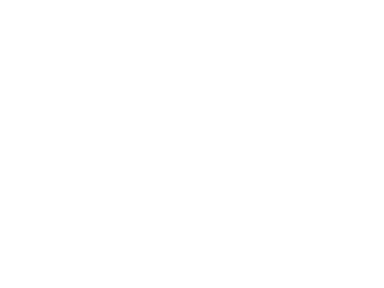

NameError: name 'positions_new_sansOutliers' is not defined

In [10]:
### Take a quick look at one of the pixel's traces
## Check for significant outliers
%matplotlib notebook

pixelNum_toUse = 300

plt.figure()
plt.plot(positions_new_sansOutliers[pixelNum_toUse,0,:])
# plt.figure()
# plt.plot(displacements[pixelNum_toUse,0,:])


## Convolutional dimensionality reduction
The point here is to do some denoising and to get the number of dots down to a managable number.\
In particular, it is nice for the batched CP decomposition later that the batches can be as big as possible in the temporal dimension, so doing some mild convolutional dim reduction first is helpful.

In [ ]:
## first let's make the convolutional kernel. I like the cosine kernel because it goes to zero.

width_cosKernel = 40

num_dots = pointInds_toUse.shape[0]

def makeDistanceMatrix(n , centerIdx , vid_height , vid_width):
    x,y = np.meshgrid(range(vid_width),range(vid_height)) # note dim 1:X and dim 2:Y
    return np.sqrt((y-int(centerIdx[1]))**2+(x-int(centerIdx[0]))**2)

cosKernel = np.zeros((vid_height , vid_width , num_dots))
cosKernel_mean = np.zeros(num_dots)
for ii in range(num_dots):
    x = makeDistanceMatrix(width_cosKernel , np.squeeze(pointInds_toUse)[ii] , vid_height , vid_width)
    x_norm = x / width_cosKernel
    x_clipped = np.minimum(x_norm , 1)
    cosKernel[:,:,ii] = (np.cos(x_clipped * np.pi) +1) / 2
    tmp = copy.deepcopy(cosKernel[:,:,ii])
    tmp[tmp==0] = np.nan
    cosKernel_mean[ii] = np.nanmean(tmp)

plt.figure()
plt.imshow(cosKernel[:,:,0])

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'cosKernel'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , cosKernel)

In [ ]:
## now the fun part: a bajillion dimensionality reductions

# first, let's make new dots with wider spacing

spacing = 8  ## This is the distance between points in the grid (both in x and y dims)

pts_spaced_convDR = np.ones((np.int64(bbox_subframe_displacement[3] * bbox_subframe_displacement[2] / spacing) ,2)) * np.nan ## preallocation
cc = 0 ## set idx counter
# make spaced out points
for ii in range(len(pts_x_displacement)):
    if (pts_x_displacement[ii]%spacing == 0) and (pts_y_displacement[ii]%spacing == 0):
        pts_spaced_convDR[cc,0] = pts_x_displacement[ii]
        pts_spaced_convDR[cc,1] = pts_y_displacement[ii]
        cc = cc+1

pts_spaced_convDR = np.expand_dims(pts_spaced_convDR,1).astype('single')
pts_spaced_convDR = np.delete(pts_spaced_convDR , np.where(np.isnan(pts_spaced_convDR[:,0,0])) , axis=0)
print(f'number of points: {pts_spaced_convDR.shape[0]}')

In [10]:
# now let's show the dots we just made

vidNum_toUse = 0 # 0 indexed
frameNum_toUse = 0 # 0 indexed
dot_size = 1

## Define random colors for points in cloud
color_tuples =  list(np.arange(len(pts_x_displacement)))
for ii in range(len(pts_x_displacement)):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
    
vid = imageio.get_reader(path_vid_allFiles[vidNum_toUse],  'ffmpeg')
frameToSet = 0
frame = vid.get_data(frameNum_toUse) # Get a single frame to use as the first 'previous frame' in calculating optic flow
pointInds_tuple = list(np.arange(pts_spaced_convDR.shape[0])) 
for ii in range(pts_spaced_convDR.shape[0]):
    pointInds_tuple[ii] = tuple(np.squeeze(pts_spaced_convDR[ii,0,:]))
    cv2.circle(frame,pointInds_tuple[ii], dot_size, color_tuples[ii], -1)
cv2.imshow('dots for conv dim red',frame)
k = cv2.waitKey(0)
cv2.destroyAllWindows()

number of points: 526


<ipython-input-10-e22c6cadccae>:37: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(frame,pointInds_tuple[ii], dot_size, color_tuples[ii], -1)


In [11]:
cv2.destroyAllWindows()

In [ ]:
## now let's find coefficients of influence from each original dot onto each new dot

input_traces = np.float32(positions_new_sansOutliers)
num_components = 1
rank_reduced = num_components

dots_old = pointInds_toUse
dots_new = pts_spaced_convDR

pca = sk.decomposition.PCA(n_components=num_components)

positions_convDR_meanSub = np.zeros((dots_new.shape[0] , 2 , input_traces.shape[2]))
output_PCA_loadings = np.zeros((dots_new.shape[0] , 2 , input_traces.shape[2] , num_components))
output_PCA_scores = list(np.zeros(dots_new.shape[0]))
for ii in range(dots_new.shape[0]):
#     print(ii)
    influence_weightings = cosKernel[int(dots_new[ii][0][1]) , int(dots_new[ii][0][0]) , :]
    
    idx_nonZero = np.array(np.where(influence_weightings !=0))[0,:]

    displacements_preConvDR_x = input_traces[idx_nonZero , 0 , :] * influence_weightings[idx_nonZero][:,None]
    displacements_preConvDR_x = displacements_preConvDR_x - np.mean(displacements_preConvDR_x , axis=1)[:,None]
    displacements_preConvDR_y = input_traces[idx_nonZero , 1 , :] * influence_weightings[idx_nonZero][:,None]
    displacements_preConvDR_y = displacements_preConvDR_y - np.mean(displacements_preConvDR_y , axis=1)[:,None]
    pca.fit(displacements_preConvDR_x)
    output_PCA_loadings[ii,0,:,:] = pca.components_.T
    pca.fit(displacements_preConvDR_y)
    output_PCA_loadings[ii,1,:,:] = pca.components_.T
    
    output_PCA_scores[ii] = np.zeros((2,displacements_preConvDR_y.shape[0] , num_components))
    output_PCA_scores[ii][0,:,:] = np.dot( displacements_preConvDR_x  ,  output_PCA_loadings[ii,0,:,:] )
    output_PCA_scores[ii][1,:,:] = np.dot( displacements_preConvDR_y  ,  output_PCA_loadings[ii,1,:,:] )
    positions_convDR_meanSub[ii,0,:] = np.mean(np.dot( output_PCA_loadings[ii,0,:,:rank_reduced] , output_PCA_scores[ii][0,:,:rank_reduced].T ) , axis=1) / cosKernel_mean[ii]
    positions_convDR_meanSub[ii,1,:] = np.mean(np.dot( output_PCA_loadings[ii,1,:,:rank_reduced] , output_PCA_scores[ii][1,:,:rank_reduced].T ) , axis=1) / cosKernel_mean[ii]

In [ ]:
## now let's find coefficients of influence from each original dot onto each new dot
# CAUTION: Huge memory requirement (Lower number of CPUs in the pool to decrease memory usage. For my runs (1 hr at 120hz, downsampling to ~400 dots, I use 18 cores and it
# uses around 150GB of memory. Use single thread version otherwise)

tic = time.time()

input_traces = np.float32(positions_new_sansOutliers)
num_components = 2
rank_reduced = num_components

dots_old = pointInds_toUse
dots_new = pts_spaced_convDR

pca = sk.decomposition.PCA(n_components=num_components)


def makeConvDR(ii):
#     print(ii)
    influence_weightings = cosKernel[int(dots_new[ii][0][1]) , int(dots_new[ii][0][0]) , :]
    
    idx_nonZero = np.array(np.where(influence_weightings !=0))[0,:]

    displacements_preConvDR_x = input_traces[idx_nonZero , 0 , :] * influence_weightings[idx_nonZero][:,None]
    displacements_preConvDR_x = displacements_preConvDR_x - np.mean(displacements_preConvDR_x , axis=1)[:,None]
    displacements_preConvDR_y = input_traces[idx_nonZero , 1 , :] * influence_weightings[idx_nonZero][:,None]
    displacements_preConvDR_y = displacements_preConvDR_y - np.mean(displacements_preConvDR_y , axis=1)[:,None]
    pca.fit(displacements_preConvDR_x)
    output_PCA_loadings0 = pca.components_.T
    pca.fit(displacements_preConvDR_y)
    output_PCA_loadings1 = pca.components_.T
    
    output_PCA_scores0 = np.dot( displacements_preConvDR_x  ,  output_PCA_loadings0 )
    output_PCA_scores1 = np.dot( displacements_preConvDR_y  ,  output_PCA_loadings1 )
    positions_convDR_meanSub = np.zeros((2,input_traces.shape[2]))
    positions_convDR_meanSub[0,:] = np.mean(np.dot( output_PCA_loadings0[:,:rank_reduced] , output_PCA_scores0[:,:rank_reduced].T ) , axis=1) / cosKernel_mean[ii]
    positions_convDR_meanSub[1,:] = np.mean(np.dot( output_PCA_loadings1[:,:rank_reduced] , output_PCA_scores1[:,:rank_reduced].T ) , axis=1) / cosKernel_mean[ii]
    return positions_convDR_meanSub

# p = Pool(multiprocessing.cpu_count())
p = Pool(int(multiprocessing.cpu_count()/3))
positions_convDR_meanSub_list = p.map(makeConvDR , range(dots_new.shape[0]))
p.close()
p.terminate()
p.join()

positions_convDR_meanSub = np.zeros((dots_new.shape[0] , 2 , input_traces.shape[2]))
for ii in range(dots_new.shape[0]):
    positions_convDR_meanSub[ii,:,:] = positions_convDR_meanSub_list[ii]
    
print(f'Time elapsed: {round((time.time() - tic)/60,2)} minutes')

In [ ]:
p.close()
p.terminate()
p.join()

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'positions_convDR_meanSub'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , positions_convDR_meanSub)

save_name = f'pts_spaced_convDR'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , pts_spaced_convDR)

In [14]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'

load_name = f'positions_convDR_meanSub'
load_fullPath = f'{load_dir}/{load_name}.npy'
positions_convDR_meanSub = np.load(load_fullPath)

load_name = f'pts_spaced_convDR'
load_fullPath = f'{load_dir}/{load_name}.npy'
pts_spaced_convDR = np.load(load_fullPath)


positions_convDR_absolute = (positions_convDR_meanSub + np.squeeze(pts_spaced_convDR)[:,:,None])

In [206]:
### Display video of displacement dot-grid after outlier removal
## Just for observation purposes

# positions_toUse = positions_new_absolute_sansOutliers
positions_toUse = (positions_convDR_meanSub + np.squeeze(pts_spaced_convDR)[:,:,None])

# vidNums_toUse = range(numVids) ## note zero indexing!
vidNums_toUse = range(3) ## note zero indexing!

if type(vidNums_toUse) == int:
    vidNums_toUse = np.array([vidNums_toUse])

dot_size = 1

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over


## Define random colors for points in cloud
color_tuples =  list(np.arange(positions_toUse.shape[0]))
for ii in range(positions_toUse.shape[0]):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
#     color_tuples[ii] = (0,255,255)
        
        

## Main loop to pull out displacements in each video   
ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

fps = 0
tic_fps = time.time()
for iter_vid , vidNum_iter in enumerate(vidNums_toUse):
    path_vid = path_vid_allFiles[vidNum_iter]
    vid = imageio.get_reader(path_vid,  'ffmpeg')

    video = cv2.VideoCapture(path_vid)
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for iter_frame , new_frame in enumerate(vid):
        for ii in range(positions_toUse.shape[0]):
            pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
            cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, color_tuples[ii], -1)
        
        cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}-ish', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.putText(new_frame, f'vid #: {iter_vid+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total_rough}-ish', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
        cv2.imshow('post outlier removal',new_frame)


        k = cv2.waitKey(1) & 0xff
        if k == 27 : break
            
        ind_concat = ind_concat+1

        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            

cv2.destroyAllWindows()


KeyboardInterrupt: 

In [16]:
cv2.destroyAllWindows()

# Analysis

Below you'll find the following:
- PCA done on raw positions
- Spectral analysis of every pixels to transoform the basis to be oscillatory
- TCA done on the spectra
- A lonely t-SNE plot of the temporal factors

### PCA
The X and Y displacements are concatenated and run together. Something interesting to try would be to transform to polar coordinates, concatenate and run that way. Maybe TCA on the positions with magnitude vs angle being one of the dimensions would make sense.

<IPython.core.display.Javascript object>


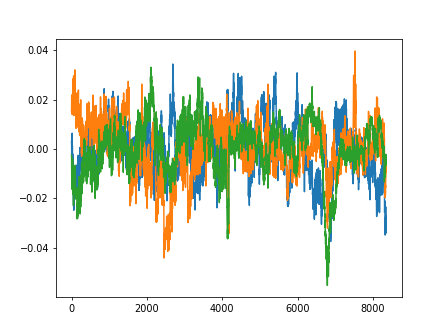

<IPython.core.display.Javascript object>


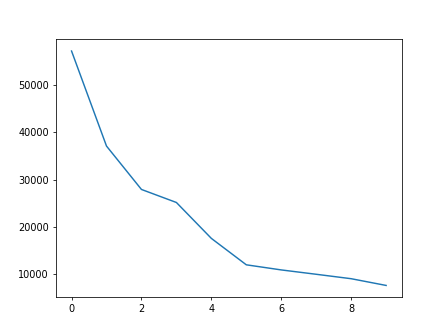

<IPython.core.display.Javascript object>


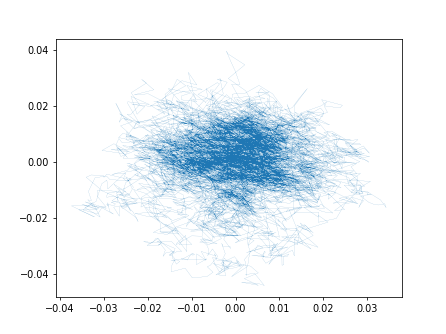

<IPython.core.display.Javascript object>


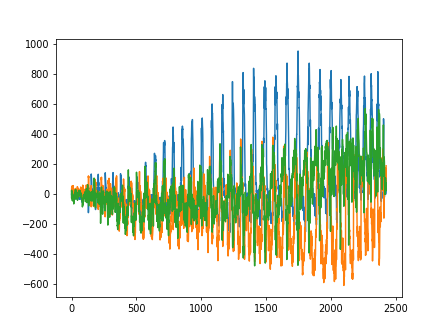

In [15]:
%matplotlib notebook
# input_dimRed = np.squeeze(positions_new_sansOutliers[:,1,:])
tmp_x = np.squeeze(positions_new_sansOutliers[:,0,:])
tmp_y = np.squeeze(positions_new_sansOutliers[:,1,:])
                   
input_dimRed_meanSub = np.concatenate((tmp_x - tmp_x.mean(1)[:,None] , tmp_y - tmp_y.mean(1)[:,None]) , axis=1 )
# input_dimRed_concat = np.concatenate( (np.squeeze(positions_new_sansOutliers[:,0,:]) , np.squeeze(positions_new_sansOutliers[:,1,:])) , axis=1)

# input_dimRed_meanSub = input_dimRed_concat - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed_concat , axis=1) , axis=1) , 1 , input_dimRed_concat.shape[1])
# input_dimRed_meanSub = input_dimRed_concat - input_dimRed_concat.mean(1)[:,None]

pca = sk.decomposition.PCA(n_components=10)
# pca = sk.decomposition.FastICA(n_components=10)
pca.fit(np.float32(input_dimRed_meanSub))
output_PCA = pca.components_.transpose()
scores_points = np.dot(input_dimRed_meanSub , output_PCA)

# plt.figure()
# plt.imshow(positions_tracked[:,])
plt.figure()
plt.plot(output_PCA[:,:3])
plt.figure()
plt.plot(pca.explained_variance_)
plt.figure()
plt.plot(output_PCA[:,0] , output_PCA[:,1]  , linewidth=.1)

plt.figure()
plt.plot(scores_points[:,:3])

In [95]:
# del input_dimRed_concat
del input_dimRed_meanSub
del tmp_x
del tmp_y
del output_PCA
gc.collect()

NameError: name 'input_dimRed_meanSub' is not defined

In [20]:
# Display PCs

positions_toUse = positions_new_absolute_sansOutliers

# vidNums_toUse = range(numVids) ## note zero indexing!
vidNums_toUse = 0 ## note zero indexing!

if type(vidNums_toUse) == int:
    vidNums_toUse = np.array([vidNums_toUse])

dot_size = 2

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

PC_toShow = 1
PC_toShow = PC_toShow-1

range_toUse = np.ceil(np.max(scores_points[:,PC_toShow]) - np.min(scores_points[:,PC_toShow])) + 1
offset_toUse = np.min(scores_points[:,PC_toShow])
scores_norm = scores_points[:,PC_toShow] - offset_toUse
scores_norm = (scores_norm / np.max(scores_norm)) *1000
cmap = matplotlib.cm.get_cmap('hot', 1000)


colormap_tuples =  list(np.arange(pointInds_toUse.shape[0]))
for ii in range(pointInds_toUse.shape[0]):
    colormap_tuples[ii] = list(np.flip((np.array(cmap(np.int64(scores_norm[ii]))) *255)[:3]))
        
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
save_pref = 0
if save_pref:
    out = cv2.VideoWriter('F:\RH_Local\Rich data\camera data\output.avi',fourcc, Fs, (vid_width, vid_height))
      

## Main loop to pull out displacements in each video   
ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

fps = 0
tic_fps = time.time()
for iter_vid , vidNum_iter in enumerate(vidNums_toUse):
    path_vid = path_vid_allFiles[vidNum_iter]
    vid = imageio.get_reader(path_vid,  'ffmpeg')
        
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for iter_frame , new_frame in enumerate(vid):
        
        for ii in range(positions_toUse.shape[0]):
            pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
            cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, colormap_tuples[ii], -1)
        if save_pref:
            out.write(new_frame)
            
        cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'vid #: {iter_vid+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
#         cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'PC #: {PC_toShow+1}', org=(10,100), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.imshow('PCs',new_frame)


        k = cv2.waitKey(1) & 0xff
        if k == 27 : break
            
        ind_concat = ind_concat+1

        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            

out.release()
video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [96]:
cv2.destroyAllWindows()

### Spectral Analysis
I've played with a few different methods. While multiresolution methods seems ideal for this use-case, It just ends up severly overrepresenting low frequency factors, making noisier high frequency factors, and doing an overall worse job at reconstruction.
A good ol' multitaper short time fourier transform seems to work fine. Adding in raw positions to subsequent dimensionality reduction later on seems like a natural thing to do, as single resolution spectral analysis ends up kind of ignoring slower dynamics.

In [114]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'

load_name = f'settings_cqt'
load_fullPath = f'{load_dir}/{load_name}.npy'
settings_cqt = np.load(load_fullPath , allow_pickle=True)[()]


hop_length = settings_cqt['hop_length']
fmin = settings_cqt['fmin']
sr = settings_cqt['sr']
bins_per_octave = settings_cqt['bins_per_octave']
n_bins = settings_cqt['n_bins']
print(settings_cqt)

{'hop_length': 16, 'fmin': 2, 'sr': 120.1634222542658, 'bins_per_octave': 10, 'n_bins': 49}


In [ ]:
eps = 1.19209e-07 # float32 epsilon

hop_length = 16
fmin_rough = 2
sr = Fs
n_bins = 50

bins_per_octave = int(np.round((n_bins) / np.log2( (Fs/2)/fmin_rough )))
fmin = ( (Fs/2)/(2**((n_bins)/bins_per_octave)) ) - (2*eps)
fmax = fmin*(2**((n_bins)/bins_per_octave))

freqs_Sxx = fmin*(2**((np.arange(n_bins)+1)/bins_per_octave))

print(f'bins_per_octave: {round(bins_per_octave)} bins/octave')
print(f'minimum frequency (fmin): {round(fmin,3)} Hz')
print(f'maximum frequency (fmax): {round(fmax,8)} Hz')
print(f'Nyquist                 : {sr/2} Hz')
print(f'number of frequencies:    {n_bins} bins')
plt.figure()
plt.plot(freqs_Sxx)
print(f'Frequencies: {np.round(freqs_Sxx , 3)}')

In [ ]:
### Parameters for multitaper short-time Fourier transform

settings_cqt =	{
    "hop_length": hop_length,  # number of samples between successive temporal samples
    "sr": sr,  # sampling rate (Fs)
    "n_bins": n_bins,  # Number of frequency bins, starting at fmin
    "bins_per_octave": bins_per_octave,  #     Number of bins per octave
    "fmin": fmin,  # Minimum frequency
    "fmax": fmax,  # Maximum frequency (just for reference, not input to librosa.cqt)
    }

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'settings_cqt'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , settings_cqt)


save_name = f'freqs_Sxx'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , freqs_Sxx)

In [ ]:
### CQT spectrogram for every pixel
## this code was previously parallelized, but it's pretty quick compared to the other steps, so might as well keep it simple

print(f'== Starting CQT spectrogram calculations ==')
tic_all = time.time()

## define positions traces to use
# input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]
input_sgram = np.single(np.squeeze(positions_convDR_meanSub))[:,:,:]

## get parameters
hop_length = hop_length
fmin_rough = fmin_rough
sr = sr
n_bins = n_bins
bins_per_octave = bins_per_octave
fmin = fmin

## make a single spectrogram to get some size parameters for preallocation
Sxx = librosa.cqt(np.squeeze(input_sgram[0,0,:]), 
                  sr=sr, 
                  hop_length=hop_length, 
                  fmin=fmin, 
                  n_bins=n_bins, 
                  bins_per_octave=bins_per_octave, 
                  window='hann')

# preallocation
tic = time.time()
print(f'preallocating')
Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , Sxx.shape[1] , 2)))  
print(f'preallocation done. Elapsed time: {round((time.time() - tic) , 2)} seconds')

print(f'starting spectrogram calculation')
for ii in range(input_sgram.shape[0]):
    ## progress tracking
    if ii%50 ==0:
        print(f'{ii} / {Sxx_allPixels.shape[0]}')
    elif ii==1:
        print(f'{ii} / {Sxx_allPixels.shape[0]}')
    
    ## iterated over x and y
    for jj in range(2):
        tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])


        tmp = librosa.cqt(np.squeeze(input_sgram[ii,jj,:]), 
                          sr=sr, 
                          hop_length=hop_length, 
                          fmin=fmin, 
                          n_bins=n_bins, 
                          bins_per_octave=bins_per_octave, 
                          window='hann')
        
        ## normalization
        tmp = abs(tmp) * freqs_Sxx[:,None]
#         tmp = scipy.stats.zscore(tmp , axis=1)
        tmp = tmp - np.min(tmp , axis=1)[:,None]

        Sxx_allPixels[ii,:,:,jj] = tmp
        
print(f'completed spectrogram calculation')
print('Info about Sxx_allPixels:\n')
print(f'Shape: {Sxx_allPixels.shape}')
print(f'Number of elements: {Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3]}')
print(f'Data type: {Sxx_allPixels.dtype}')
print(f'size of Sxx_allPixels: {round(sys.getsizeof(Sxx_allPixels)/1000000000,3)} GB')
print(f'== Spectrograms computed. Total elapsed time: {round((time.time() - tic_all)/60 , 2)} minutes ==')
      

<IPython.core.display.Javascript object>


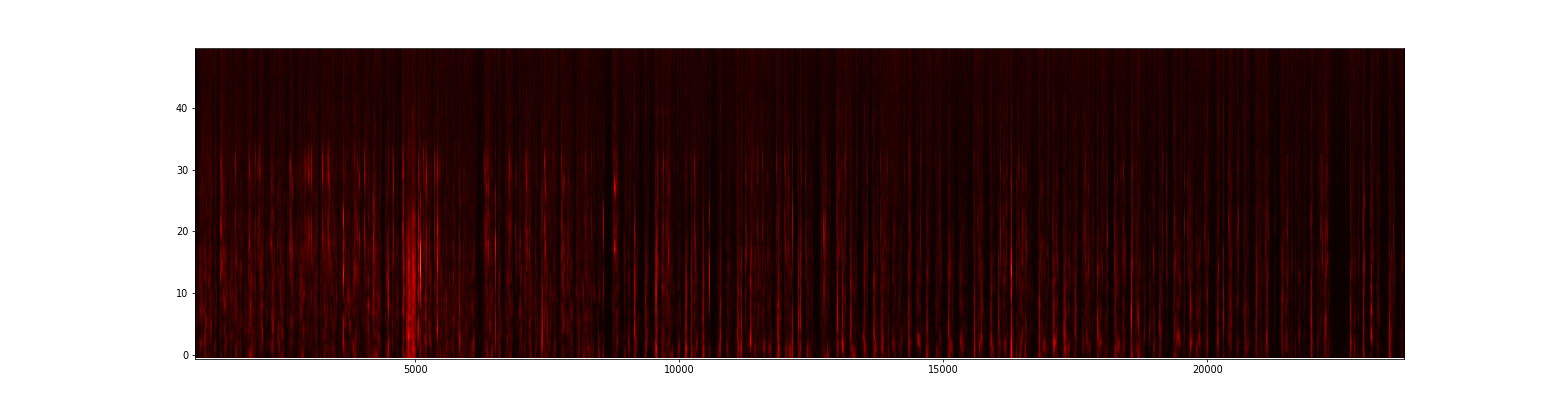

In [208]:
plt.figure()
plt.imshow(Sxx_allPixels[10,:,:,0]  , aspect='auto' , cmap='hot' , origin='lower')


In [47]:
# ### Parameters for multitaper short-time Fourier transform

# win_len = 0.6
# settings_stft =	{
#     "win_len": win_len,  # duration of each STFT. Bigger values give better spectral resolution but worse temporal resolution
#     "win_overlap": win_len*0.9,  # how much each Win_len window overlaps from sample to sample. ranges from 0-win_len. Bigger values mean more temporal samples
#     'nw': 3,  # standardized half bandwidth. Similar tradeoffs to scaling win_len
#     'ntapers': 1, # number of tapers. Keep around 1-2 for most purposes, 3 for very noisy data
#     'fs': int(np.round(Fs)) } # sample rate

In [209]:
# ### Multitapered spectrogram for every pixel
# ## this code was previously parallelized, but it's pretty quick compared to the other steps, so might as well keep it simple

# print(f'== Starting spectrogram calculations ==')
# tic_all = time.time()

# ## define positions traces to use
# # input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]
# input_sgram = np.single(np.squeeze(positions_convDR_meanSub))[:,:,:]

# ## get parameters
# win_len = settings_stft['win_len']
# win_overlap = settings_stft['win_overlap']
# nw = settings_stft['nw']
# ntapers = settings_stft['ntapers']
# fs = settings_stft['fs']

# ## make a single spectrogram to get some size parameters for preallocation
# freqs_Sxx , t , Sxx = mtaper_specgram.mtaper_specgram(np.squeeze(input_sgram[0,0,:]) ,     
#     nw=nw,
#     ntapers = ntapers,
#     win_len = win_len,
#     win_overlap = win_overlap,
#     fs=fs,
#     clip=None,)

# # preallocation
# tic = time.time()
# print(f'preallocating')
# Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , Sxx.shape[1] , 2)))  
# print(f'preallocation done. Elapsed time: {round((time.time() - tic) , 2)} seconds')

# print(f'starting spectrogram calculation')
# for ii in range(input_sgram.shape[0]):
#     ## progress tracking
#     if ii%50 ==0:
#         print(f'{ii} / {Sxx_allPixels.shape[0]}')
#     elif ii==1:
#         print(f'{ii} / {Sxx_allPixels.shape[0]}')
    
#     ## iterated over x and y
#     for jj in range(2):
#         tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])


#         freqs_Sxx , t , tmp = mtaper_specgram.mtaper_specgram(tmp_input_sgram ,     
#             nw=nw,
#             ntapers = ntapers,
#             win_len = win_len,
#             win_overlap = win_overlap,
#             fs=fs,
#             clip=None,)
        
#         ## normalization
#         tmp = scipy.stats.zscore(tmp , axis=1)
#         tmp = tmp - np.min(tmp , axis=1)[:,None]

#         Sxx_allPixels[ii,:,:,jj] = tmp
        
# print(f'completed spectrogram calculation')
# print('Info about Sxx_allPixels:\n')
# print(f'Shape: {Sxx_allPixels.shape}')
# print(f'Number of elements: {Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3]}')
# print(f'Data type: {Sxx_allPixels.dtype}')
# print(f'size of Sxx_allPixels: {round(sys.getsizeof(Sxx_allPixels)/1000000000,3)} GB')
# print(f'== Spectrograms computed. Total elapsed time: {round((time.time() - tic_all)/60 , 2)} minutes ==')
      

In [210]:
# gc.collect()

In [211]:
# ## wavelet scalogram for every pixel
# # IGNORE FOR NOW

# %matplotlib notebook

# tic = time.time()

# input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]


# tmp = np.squeeze(input_sgram[0,0,:])
# t = np.arange(len(tmp)) / Fs
# dt = t[1] - t[0]
# wavelet = 'cmor3-1.0'
# # wavelet = 'shan30-10.0'
# # scales_log_base = 10
# scales_expOrder = 2
# scales_start = 2 # in scales relative to 1/dt (half of nyquist)
# scales_stop = Fs
# scales_num = 50 # number of scales to use
# decimation_factor = 1

# # scales = np.logspace(math.log(scales_start,scales_log_base), math.log(scales_stop,scales_log_base), num=scales_num, base=scales_log_base)
# scales = ( (np.linspace(0 , 1 , scales_num) ** scales_expOrder) * (scales_stop - scales_start) ) + scales_start
# # print(scales)
# plt.figure()
# plt.plot(scales)
# plt.xlabel('scale ind')
# plt.ylabel('scale value')

# [Sxx, freqs_Sxx] = pywt.cwt(np.squeeze(input_sgram[0,0,:]), scales, wavelet, dt)
# Sxx = (abs(Sxx)) ** 2
# Sxx = Sxx / np.std(Sxx , axis=1)[:,None]

# plt.figure()
# plt.imshow(Sxx , aspect='auto' , cmap='hot' , origin='lower')

# # print(Sxx.shape)

# # for ii in range(input_sgram.shape[0]):
# def makeSxx(ii):
# #     if ii%5 ==0:
#     print(f'\n {ii} / {input_sgram.shape[0]}')
#     for jj in range(2):
#         tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])

#         [tmp, freqs_Sxx] = pywt.cwt(tmp_input_sgram, scales, wavelet, dt)
#         tmp = (abs(tmp)) ** 2

# #         tmp = scipy.stats.zscore(tmp , axis=1)
#         tmp = tmp / np.std(tmp , axis=1)[:,None]
# #         tmp = scipy.signal.decimate(tmp, decimation_factor, ftype='fir', axis=1, zero_phase=True)
#         tmp = tmp[:,np.uint32(np.arange(0,tmp.shape[1], decimation_factor))]
# #         tmp = tmp - np.min(tmp , axis=1)[:,None]

#         if jj==1:
#             Sxx = np.concatenate((tmp1[:,:,None] , tmp[:,:,None]) , axis=2)
#         tmp1 = tmp


# #         Sxx_allPixels[ii,:,:,jj] = tmp
#     return Sxx
# p = Pool(multiprocessing.cpu_count())
# Sxx_allPixels_list = p.map(makeSxx , list(np.arange(input_sgram.shape[0])))

# p.close()
# p.terminate()
# p.join()

# Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , np.uint32(np.ceil(Sxx.shape[1]/decimation_factor)) , 2)))
# for ii in range(len(Sxx_allPixels_list)):
#     Sxx_allPixels[ii,:,:,:] = Sxx_allPixels_list[ii]
    

# toc = time.time() - tic
# print(f'elapsed time: {toc}')

# print('Info about Sxx_allPixels:\n')
# print(f'Shape: {Sxx_allPixels.shape}')
# print(f'Number of elements: {Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3]}')
# print(f'Data type: {Sxx_allPixels.dtype}')
# print(f'size of Sxx_allPixels: {sys.getsizeof(Sxx_allPixels)/1000000000} GB')

In [212]:
# ### Sample spectrogram

# %matplotlib notebook

# plt.figure()
# plt.imshow(Sxx_allPixels[600,:,:,0]  , aspect='auto' , cmap='hot' , origin='lower')


### Saving & Loading before TCA

In [22]:
# settings_wavelet =	{
#     "t": t,
#     "dt": dt,
#     "wavelet": 'cmor3-1.0',
#     'scales_log_base': scales_log_base,
#     'scales_start': scales_start,
#     'scales_stop': scales_stop,
#     'scales_num': scales_num,
#     'scales': scales,
#     'decimation_factor': decimation_factor }



# save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam1/run1'


# save_name = f'settings_wavelet'
# save_fullPath = f'{save_dir}/{save_name}.npy'
# np.save(save_fullPath , settings_wavelet)

In [16]:
# save_dir = f'/media/rich/bigSSD RH/tmp_download'

# save_name = f'settings_stft'
# save_fullPath = f'{save_dir}/{save_name}.npy'
# np.save(save_fullPath , settings_stft)

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'Sxx_allPixels'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , Sxx_allPixels)


save_name = f'freqs_Sxx'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , freqs_Sxx)

In [8]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2'

load_name = f'freqs_Sxx'
load_fullPath = f'{load_dir}/{load_name}.npy'
freqs_Sxx = np.load(load_fullPath)

load_name = f'Sxx_allPixels'
load_fullPath = f'{load_dir}/{load_name}.npy'
Sxx_allPixels = np.load(load_fullPath)

load_name = f'Fs'
load_fullPath = f'{load_dir}/{load_name}.npy'
Fs = np.load(load_fullPath)

FileNotFoundError: [Errno 2] No such file or directory: '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2/Fs.npy'

### TCA
There are two major tensor packages, one is tensortools (made by an acquaintance named Alex Williams) and the other is Tensorly.
Tensorly seems to be more packaged up and has some options to use some advanced backends like torch, tf, and mxnet. Though there are
a couple of nice features in tensortools that Tensorly doesn't have, though. Generally tensortools gives better reconstructions, but takes
much longer to do it.

In [6]:
### TENSORTOOLS

# # input_dimRed_x = np.squeeze(positions_sansOutliers_smoothed[:,0,:])
# # input_dimRed_meanSub_x = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])
# # input_dimRed_y = np.squeeze(positions_sansOutliers_smoothed[:,1,:])
# # input_dimRed_meanSub_y = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])


# # data = np.dstack((input_dimRed_x , input_dimRed_y))# ... specify a numpy array holding the tensor you wish to fit
# data = Sxx_allPixels
# print(f'shape of data: {data.shape}')

# # Fit an ensemble of models, 4 random replicates / optimization runs per model rank
# ensemble = tt.Ensemble(fit_method="ncp_hals")
# ensemble.fit(data, ranks=range(5, 6), replicates=1)

In [7]:
# ensemble_normGram = copy.deepcopy(ensemble)
# # ensemble_lessOverlap = copy.deepcopy(ensemble)

In [8]:
# ensemble_toUse = ensemble

# fig, axes = plt.subplots(1, 2)
# tt.plot_objective(ensemble_toUse, ax=axes[0])   # plot reconstruction error as a function of num components.
# # tt.plot_similarity(ensemble_toUse, ax=axes[1])  # plot model similarity as a function of num components.
# fig.tight_layout()

In [9]:
# modelRank_toUse = 5
# modelIter_toUse = 0

# ensemble_toUse = ensemble

# plt.figure()
# # plt.plot(np.arange(ensemble_toUse.factors(4)[0][2].shape[0])/Fs , ensemble_toUse.factors(4)[0][2])
# factors_temporal = scipy.stats.zscore(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2][:,:] , axis=0)
# plt.plot(factors_temporal)
# plt.figure()
# plt.plot(f , ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][1])
# plt.figure()
# plt.plot(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][3])
# plt.figure()
# plt.plot(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][0])

# plt.figure()
# plt.imshow(np.corrcoef(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2].transpose()))

# input_dimRed = ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2]
# # input_dimRed_meanSub = 
# pca = sk.decomposition.PCA(n_components=modelRank_toUse-2)
# # pca = sk.decomposition.FactorAnalysis(n_components=3)
# pca.fit(input_dimRed.transpose())
# output_PCA = pca.components_.transpose()
# # scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

# plt.figure()
# plt.plot(output_PCA)

In [10]:
# del positions_new_sansOutliers
# gc.collect()

In [ ]:
### Prepare Tensorly

pref_useGPU = 0


tl.set_backend('pytorch')

# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.
if pref_useGPU:
    cuda_device_number = torch.cuda.current_device()
    print(f"using CUDA device: 'cuda:{cuda_device_number}'")
    device = f'cuda:{cuda_device_number}'
else:
    print(f"using CPU")
    device = 'cpu'  


## Prepare the input tensor
print(f'== Starting loading tensor ==')
tic = time.time()
Sxx_allPixels_tensor = tl.tensor(Sxx_allPixels[:,:,:,:], dtype=tl.float32, device=device, requires_grad=False)
print(f'== Finished loading tensor. Elapsed time: {round(time.time() - tic,2)} seconds ==')

print(f'Size of input (spectrogram): {Sxx_allPixels_tensor.shape}')

print(f'{round(sys.getsizeof(Sxx_allPixels)/1000000000,3)} GB')

In [ ]:
del Sxx_allPixels
gc.collect()

In [ ]:
### Fit TCA model
## If the input is small, set init='svd'

rank = 8

weights, factors = tensorly.decomposition.non_negative_parafac(Sxx_allPixels_tensor[:,:,:,:], init='random', tol=1e-07, n_iter_max=1000, rank=rank, verbose=True, orthogonalise=False, random_state=1234)
# weights, factors = tensorly.decomposition.non_negative_parafac(Sxx_allPixels_tensor[:,:,:,:], init='svd', tol=1e-05, n_iter_max=100, rank=rank, verbose=True,)
# weights, factors = tensorly.decomposition.parafac(Sxx_allPixels_tensor, init='random', tol=1e-05, n_iter_max=1000, rank=rank, verbose=True)

In [ ]:
## make numpy version of tensorly output

factors_toUse = factors


if pref_useGPU:
    factors_np = list(np.arange(len(factors)))
    for ii in range(len(factors)):
#         factors_np[ii] = tl.tensor(factors[ii] , dtype=tl.float32 , device='cpu')
        factors_np[ii] = factors[ii].cpu().clone().detach().numpy()
else:
    factors_np = []
    for ii in range(len(factors_toUse)):
        factors_np.append(np.array(factors_toUse[ii]))

In [ ]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run7'

save_name = f'factors_np'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , factors_np)

In [17]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'

load_name = f'factors_np_batchCPsqrt'
load_fullPath = f'{load_dir}/{load_name}.npy'
factors_np = np.load(load_fullPath , allow_pickle=True)

load_name = f'freqs_Sxx'
load_fullPath = f'{load_dir}/{load_name}.npy'

freqs_Sxx = np.load(load_fullPath)

In [ ]:
%matplotlib notebook

factors_toUse = factors_np
modelRank = factors_toUse[0].shape[1]
## just for plotting in case 
if 'Fs' not in globals():
    Fs = 120

plt.figure()
# plt.plot(np.arange(factors_toUse.factors(4)[0][2].shape[0])/Fs , factors_toUse.factors(4)[0][2])
factors_temporal = scipy.stats.zscore(factors_toUse[2][:,:] , axis=0)
factors_temporal = factors_toUse[2][:,:]
# factors_temporal = scipy.stats.zscore(factors_temporal_reconstructed , axis=0)
# plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,])
# plt.plot(factors_temporal[:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('time (s)')
plt.ylabel('a.u.')

plt.figure()
plt.plot(freqs_Sxx , (factors_toUse[1][:,:]))
# plt.plot(freqXaxis , (factors_toUse[1][:,:]))
# plt.plot(f , (factors_toUse[1][:,:]))
# plt.plot((factors_toUse[1][:,:]))
plt.legend(np.arange(modelRank)+1)
plt.xlabel('frequency (Hz)')
plt.ylabel('a.u.')
# plt.xscale('log')

plt.figure()
plt.plot(factors_toUse[3][:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('x vs. y')
plt.ylabel('a.u.')

plt.figure()
plt.plot(factors_toUse[0][:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('pixel number')
plt.ylabel('a.u.')


# plt.figure()
# plt.imshow(np.single(np.corrcoef(factors_toUse[2][:,:])))

input_dimRed = factors_toUse[2][:,:]
# input_dimRed_meanSub = 
pca = sk.decomposition.PCA(n_components=modelRank-2)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

plt.figure()
plt.plot(output_PCA)

In [13]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run6'
load_name = f'positions_convDR_meanSub'
load_fullPath = f'{load_dir}/{load_name}.npy'

positions_convDR_meanSub = np.load(load_fullPath)

In [231]:
positions_new_absolute_sansOutliers = positions_convDR_meanSub + np.squeeze(pts_spaced_convDR)[:,:,None]

In [19]:
# Display video of factors

factors_toShow = np.arange(factors_np[0].shape[1])  # zero-indexed
# factors_toShow = [3]  # zero-indexed

for factor_iter in factors_toShow:

    # vidNums_toUse = range(numVids) ## note zero indexing!
    vidNums_toUse = 0 ## note zero indexing!

    if type(vidNums_toUse) == int:
        vidNums_toUse = np.array([vidNums_toUse])

    dot_size = 2

    printFPS_pref = 0
    fps_counterPeriod = 10 ## number of frames to do a tic toc over

#     modelRank_toUse = 5
    factor_toShow = factor_iter+1
    save_pref= 0

    # save_dir = "F:\\RH_Local\\Rich data\\camera data"
    save_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
    save_fileName = f'factor {factor_toShow}'
    # save_pathFull = f'{save_dir}\\{save_fileName}.avi'
    save_pathFull = f'{save_dir}/{save_fileName}.avi'

    # ensemble_toUse = ensemble
    ensemble_toUse = factors_np
    positions_toUse = positions_convDR_absolute

    factor_toShow = factor_toShow-1
    # input_scores = ensemble_toUse.factors(modelRank_toUse)[0][0]
    input_scores = np.single(ensemble_toUse[0])

    range_toUse = np.ceil(np.max(input_scores[:,factor_toShow]) - np.min(input_scores[:,factor_toShow])) + 1
    offset_toUse = np.min(input_scores[:,factor_toShow])
    scores_norm = input_scores[:,factor_toShow] - offset_toUse
    scores_norm = (scores_norm / np.max(scores_norm)) *1000
    cmap = matplotlib.cm.get_cmap('hot', 1000)
    # cmap_viridis(np.arange(range_toUse))

    colormap_tuples =  list(np.arange(positions_toUse.shape[0]))
    for ii in range(positions_toUse.shape[0]):
        colormap_tuples[ii] = list(np.flip((np.array(cmap(np.int64(scores_norm[ii]))) *255)[:3]))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    if save_pref:
        print(f'saving to file {save_pathFull}')
        out = cv2.VideoWriter(save_pathFull, fourcc, Fs, (np.int64(vid_width), np.int64(vid_height)))


    ## Main loop to pull out displacements in each video   
    ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

    fps = 0
    tic_fps = time.time()
    for iter_vid , vidNum_iter in enumerate(vidNums_toUse):
        path_vid = path_vid_allFiles[vidNum_iter]
        vid = imageio.get_reader(path_vid,  'ffmpeg')

#         numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        numFrames = 1000

#         frameToSet = 0
#         video.set(1,frameToSet)

        for iter_frame , new_frame in enumerate(vid):

#             ind_currentVid = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
            if iter_frame >= numFrames:
                break
#             ok, new_frame = video.read()

            for ii in range(positions_toUse.shape[0]):
                pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
                cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, colormap_tuples[ii], -1)
            if save_pref:
                out.write(new_frame)

#             Sxx_frameNum = round( ind_currentVid / (positions_toUse.shape[2] / Sxx_allPixels.shape[2]) ,1)
            cv2.putText(new_frame, f'frame #: {iter_frame}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'frame #: {Sxx_frameNum}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
#             cv2.putText(new_frame, f'vid #: {iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{positions_toUse.shape[2]}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'factor num: {factor_iter+1} / {np.max(factors_toShow)+1}', org=(10,100), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.imshow('test',new_frame)


            k = cv2.waitKey(1) & 0xff
            if k == 27 : break

            ind_concat = ind_concat+1


            if ind_concat%fps_counterPeriod==0:
                elapsed = time.time() - tic_fps
                fps = fps_counterPeriod/elapsed
                if printFPS_pref:
                    print(fps)
                tic_fps = time.time()


out.release()
video.release()
cv2.destroyAllWindows()

NameError: name 'out' is not defined

In [20]:
cv2.destroyAllWindows()

In [ ]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca',
                     random_state=0, perplexity=5000)
X_tsne = tsne.fit_transform(factors_temporal)
print("Finished computing t-SNE embedding")


In [ ]:
factor_toCMap = 1  # 1 indexed

plt.figure(figsize=(5,5))
plt.plot(X_tsne[:,0] , X_tsne[:,1] , linewidth=0.1)
# plt.scatter(X_tsne[:,0] , X_tsne[:,1], 'r.' , markersize=0.6)
plt.scatter(X_tsne[:,0] , X_tsne[:,1] , s=0.3, c=factors_temporal[:,factor_toCMap-1] , cmap='jet')


In [ ]:
# das it

In [40]:
torch.cuda.empty_cache()